In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans  # Or other clustering algorithms
import tensorflow as tf

In [2]:
# Load MNIST data
mnist = fetch_openml('mnist_784', version=1, cache=True)
X, y = mnist["data"], mnist["target"].astype(np.uint8)

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
len(X)

70000

In [4]:
lambda_val = 0.1  # Example: compression factor: Reduce data by a factor of 10
epsilon = 1e-4  # Tolerance
t_max = 100   # max_iterations
num_clusters = int(len(X_train) * lambda_val)
learning_rate = 0.01  # For gradient descent
w_0 = np.random.randn(784, 10)  # initial weights:: Example: Weights for a simple linear model

In [5]:
# clustering_algorithm = KMeans(n_clusters=num_clusters, random_state=42)
# clustering_algorithm = DBSCAN()
clustering_algorithm = MiniBatchKMeans(n_clusters=num_clusters, random_state=42, batch_size=1000, n_init=3)

In [6]:
clusters = clustering_algorithm.fit_predict(X_train)
centroids = clustering_algorithm.cluster_centers_

In [7]:
len(clusters)

56000

In [8]:
len(centroids)

5600

In [9]:
len(X_train[clusters == 1])

12

In [10]:
len(y_train[clusters == 1])

12

In [11]:
# Assigning the representative labels h_k
h_k = np.zeros(len(centroids), dtype=np.uint8)
for i in range(len(centroids)):
    cluster_points = X_train[clusters == i]
    cluster_labels = y_train[clusters == i]
    # Assign the most frequent label in the cluster
    if len(cluster_labels) > 0:
      h_k[i] = np.bincount(cluster_labels).argmax()

In [12]:
h_k, len(h_k)

(array([4, 5, 3, ..., 7, 6, 0], dtype=uint8), 5600)

In [13]:
## Numpy implementation (can be less efficient)
# def compute_gradient(X, y, weights):
#     """Computes the gradient of the loss function."""
#     logits = X @ weights   ## np.matmul(X, weights)
#     probabilities = tf.nn.softmax(logits).numpy()
#     one_hot_labels = np.eye(10)[y] ## creates an identity matrix of size 10x10, and then we use the labels (y) to select the appropriate row from this matrix
#     loss_gradient = X.T @ (probabilities - one_hot_labels)
#     return loss_gradient

In [19]:
## Tensorflow approach (Uses GPU and significantly speeding up the process)
def compute_gradient_tf(X, y, weights):
    """Computes the gradient of the loss function using TensorFlow."""
    # Convert weights to a TensorFlow variable
    weights_tf = tf.Variable(weights)
    with tf.GradientTape() as tape:
        logits = X @ weights_tf  # Use the TensorFlow variable here
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            labels=tf.one_hot(y, depth=10), logits=logits
        ))
    gradient = tape.gradient(loss, weights_tf)  # Calculate gradient with respect to the TensorFlow variable
    return gradient.numpy()

In [20]:
weights = w_0.copy()
for iteration in range(t_max):
    previous_centroids = centroids.copy()

    for cluster_idx in range(len(centroids)):
        cluster_points = X_train[clusters == cluster_idx]
        cluster_labels = y_train[clusters == cluster_idx]

        # Original data gradient
        original_gradient = compute_gradient_tf(cluster_points, cluster_labels, weights)

        # Compressed data gradient
        compressed_gradient = compute_gradient_tf(centroids[cluster_idx].reshape(1, -1), np.array([h_k[cluster_idx]]), weights)

        # Update centroid
        centroids[cluster_idx] -= learning_rate * (original_gradient - compressed_gradient).mean(axis=1)

    print(f"Iteration {iteration + 1}, Max centroid change: {np.max(np.linalg.norm(centroids - previous_centroids, axis=1))}")

     # Check for convergence
    if np.max(np.linalg.norm(centroids - previous_centroids, axis=1)) <= epsilon:
        break

Iteration 1, Max centroid change: 1.5993360207877823e-17


In [ ]:
# for iteration in range(t_max):
#     previous_centroids = centroids.copy()

#     for cluster_idx in range(len(centroids)):
#         cluster_points = X_train[clusters == cluster_idx]
#         cluster_labels = y_train[clusters == cluster_idx]


#         w_hat_prime = w_0.copy()

#         # Original data gradient
#         if cluster_idx == 0:
#           w = weights
#           w_prime = w_0.copy()
#         else:
#           w = w_prime

#         w_prime -= learning_rate * compute_gradient(cluster_points, cluster_labels, w)

#         # original_gradient = compute_gradient(cluster_points, cluster_labels, weights)
#         # w_prime -= learning_rate * original_gradient

#         # Compressed data gradient
#         if cluster_idx == 0:
#           w_hat = weights
#         else:
#           w_hat = w_hat_prime

#         w_hat_prime = w_hat_prime - learning_rate * compute_gradient(cluster_points, cluster_labels, w_hat)

#         # compressed_gradient = compute_gradient(centroids[cluster_idx].reshape(1, -1), np.array([h_k[cluster_idx]]), weights)

#         # Update centroid
#         # centroids[cluster_idx] -= learning_rate * (original_gradient - compressed_gradient).mean(axis=1)
#         dim_c = centroids[cluster_idx].shape[0]
#         dim_w = w[0].shape[1]
#         w_diff_new = w_hat_prime[0] - w_prime[0]  # \(w' - \hat{w}'\)
#         w_diff_old = w_hat[0] - w[0]  # \(w - \hat{w}\)
#         update_term_1 = np.ones((dim_c, dim_w)) @ w_diff_new
#         update_term_2 = np.ones((dim_c, dim_w)) @ w_diff_old
#         update_term = update_term_1 - update_term_2
#         centroids[cluster_idx] += update_term.mean(axis = 1)

#     print(f"Iteration {iteration + 1}, Max centroid change: {np.max(np.linalg.norm(centroids - previous_centroids, axis=1))}")

#      # Check for convergence
#     if np.max(np.linalg.norm(centroids - previous_centroids, axis=1)) < epsilon:
#         break

In [21]:
compressed_X = centroids
compressed_y = h_k

In [22]:
len(compressed_X)

5600

In [23]:
len(X_train)

56000

In [24]:
len(compressed_y)

5600

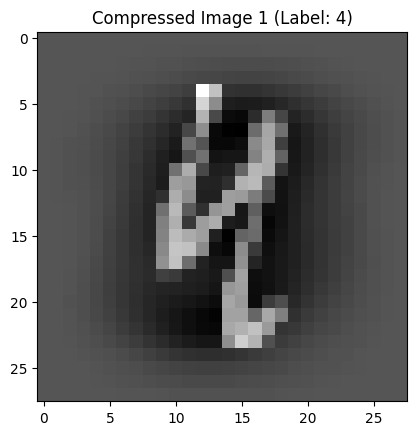

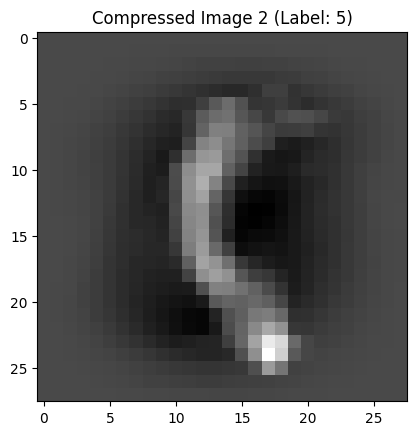

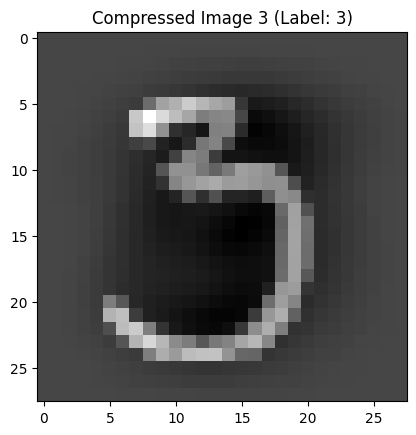

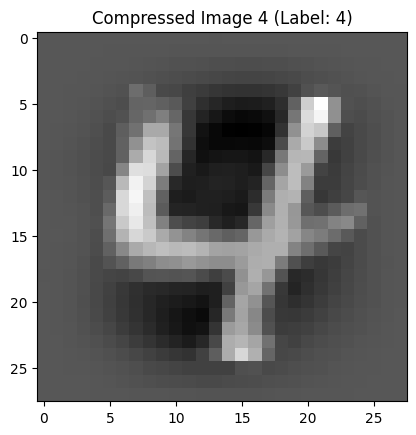

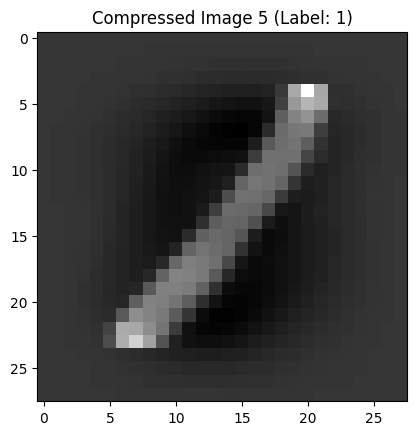

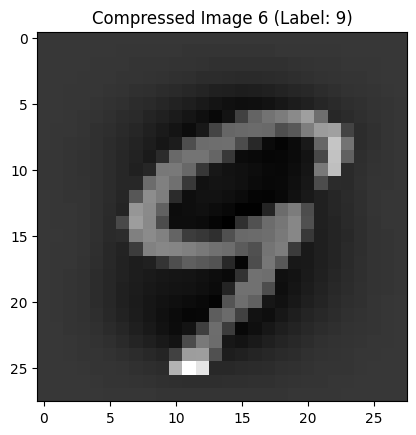

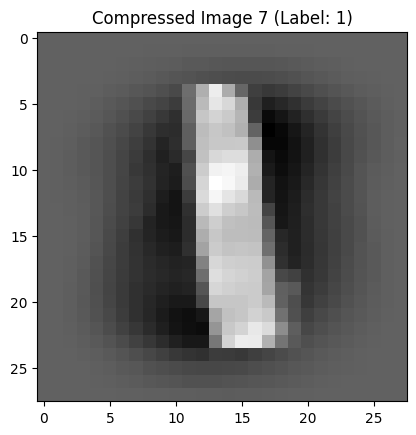

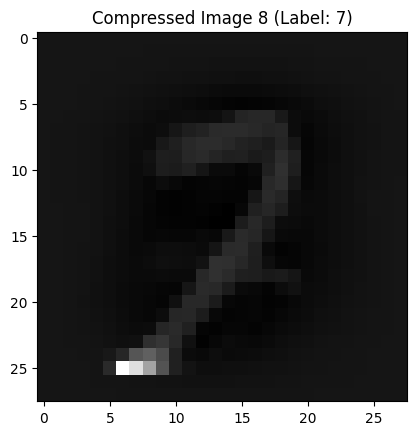

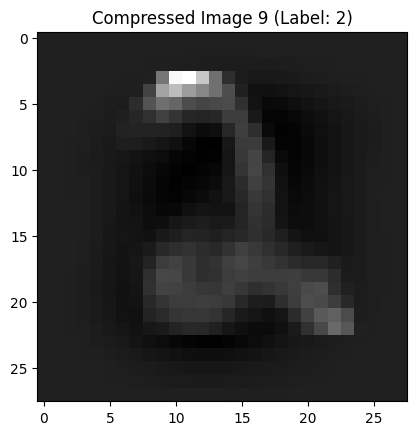

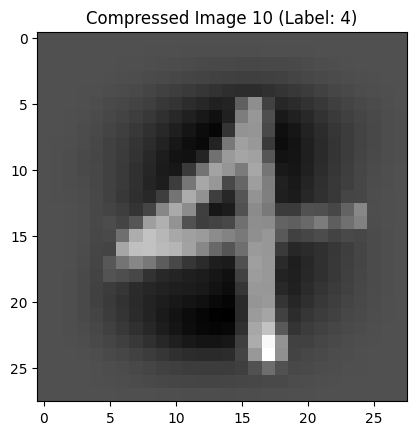

In [25]:
# prompt: how to check the compressed_X images

import matplotlib.pyplot as plt

# Assuming compressed_X contains the centroids and is a NumPy array
# Reshape the centroids to the original image dimensions (28x28)
for i in range(min(len(compressed_X), 10)):  # Display the first 10 images
    image = compressed_X[i].reshape(28, 28)
    plt.imshow(image, cmap='gray')
    plt.title(f"Compressed Image {i + 1} (Label: {compressed_y[i]})")
    plt.show()


In [28]:
# Train a model on the compressed data
model_c = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_c.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_compressed = model_c.fit(compressed_X, compressed_y, epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7268 - loss: 1.0070
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9348 - loss: 0.2481
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9571 - loss: 0.1644
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9747 - loss: 0.1071
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9805 - loss: 0.0899
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9871 - loss: 0.0631
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9880 - loss: 0.0586
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9922 - loss: 0.0417
Epoch 9/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9916 - loss: 0.0404
Epoch 10/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9937 - loss: 0.0342


In [29]:
# Train a model on the original data
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_original = model.fit(X_train, y_train, epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8901 - loss: 0.3791
Epoch 2/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9680 - loss: 0.1071
Epoch 3/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9799 - loss: 0.0657
Epoch 4/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9864 - loss: 0.0462
Epoch 5/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9882 - loss: 0.0352
Epoch 6/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9916 - loss: 0.0277
Epoch 7/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9921 - loss: 0.0247
Epoch 8/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9931 - loss: 0.0228
Epoch 9/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9944 - loss: 0.0202
Epoch 10/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9952 - loss: 0.0157


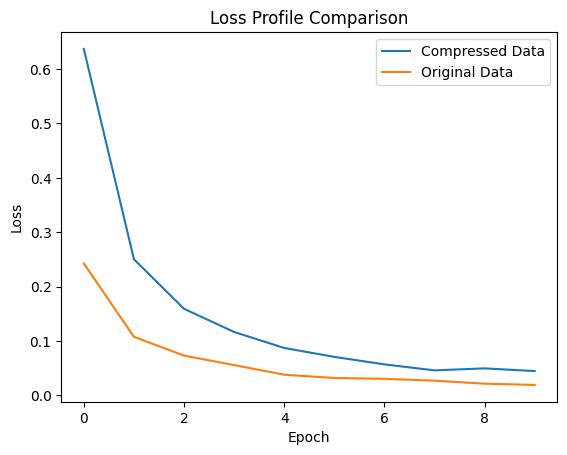

In [30]:
import matplotlib.pyplot as plt

loss_compressed = history_compressed.history['loss']
loss_original = history_original.history['loss']

# Plot the loss profiles
plt.plot(loss_compressed, label="Compressed Data")
plt.plot(loss_original, label="Original Data")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Profile Comparison")
plt.legend()
plt.show()
